In [1]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

In [2]:
df = pd.read_csv("dataframe_12g_5m.csv")
n_days = 11
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
df.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-19 15:20:00+00:00,29.55,41.00,1017.5,0.0
2020-07-19 15:25:00+00:00,29.55,41.10,1017.5,0.0
2020-07-19 15:30:00+00:00,29.55,41.05,1017.5,0.0
2020-07-19 15:35:00+00:00,29.55,41.00,1017.5,0.0
2020-07-19 15:40:00+00:00,29.55,41.05,1017.5,0.0


In [3]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())
print(df['people'].isnull().sum())

0
0
0
0


In [4]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')
df['people'] = df['people'].fillna(method='backfill').fillna(method='ffill')

In [5]:
points_per_day = int(len(df)/n_days) 
points_per_day

314

In [6]:
# divide in train e test
size = len(df)- (points_per_day*1)
# size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [7]:
start_date = df_test.index[0]
end_date = df_test.index[24]#df_test.index[points_per_day-1]

# Temperature

In [8]:
# fit model
#model = ExponentialSmoothing(df_train.temperature, seasonal="add",seasonal_periods = 288)#trend = "add")#, seasonal = "mul", seasonal_periods=500)
#model_fit = model.fit()#optimized=True)#, use_boxcox=True, remove_bias=True)

model = VARMAX(df_train[['temperature', 'humidity', 'people','pressure']], order=(1, 0))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


                                           Statespace Model Results                                          
Dep. Variable:     ['temperature', 'humidity', 'people', 'pressure']   No. Observations:                 3142
Model:                                                        VAR(1)   Log Likelihood                3559.420
                                                         + intercept   AIC                          -7058.840
Date:                                               Mon, 20 Jul 2020   BIC                          -6877.261
Time:                                                       17:57:23   HQIC                         -6993.680
Sample:                                                   07-07-2020                                         
                                                        - 07-18-2020                                         
Covariance Type:                                                 opg                                         
Ljung-Box 

In [9]:
end_pred = 24 #points_per_day-1
df_forecast = model_fit.forecast(end_pred)

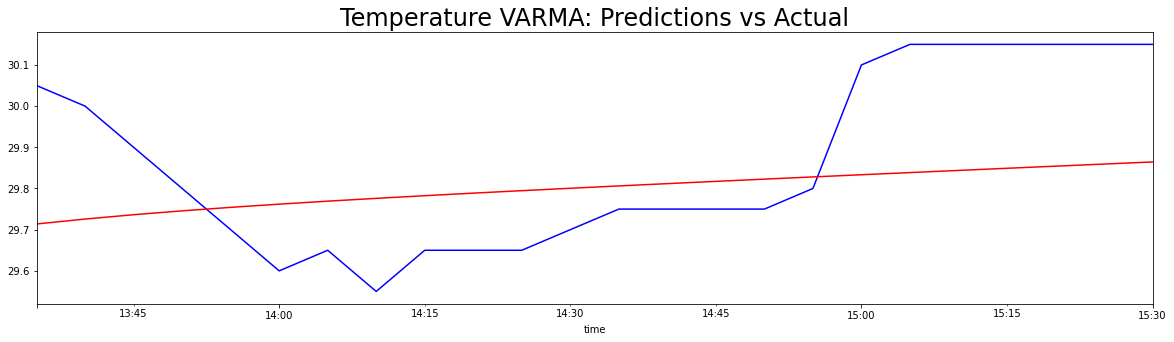

MAE 0.17705642247487896
MSE 0.04181924930353758


In [10]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.temperature.plot(color = "red")
plt.title("Temperature VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[:end_pred], df_forecast.temperature)))
print("MSE "+str(mean_squared_error(df_test.temperature[:end_pred], df_forecast.temperature)))

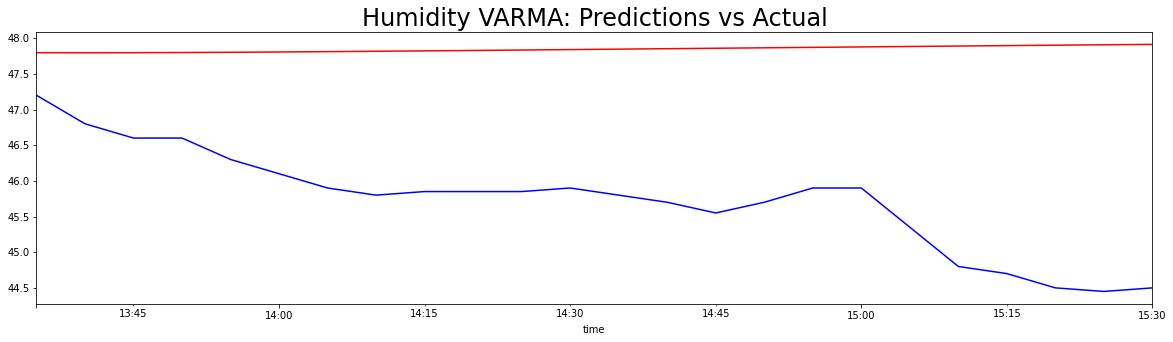

MAE 2.1129374839575585
MSE 5.024669294959088


In [11]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.humidity.plot(color = "red")
plt.title("Humidity VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[:end_pred], df_forecast.humidity)))
print("MSE "+str(mean_squared_error(df_test.humidity[:end_pred], df_forecast.humidity)))

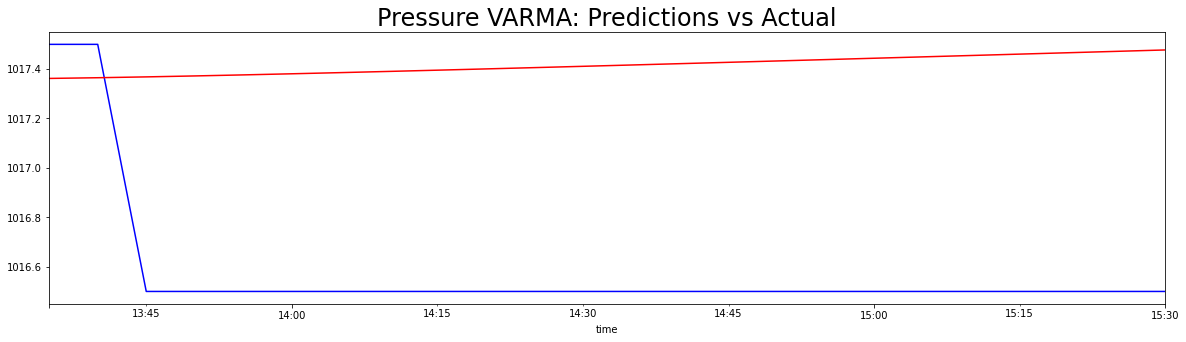

MAE 0.8550098000038228
MSE 0.7790027022499292


In [12]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.pressure.plot(color = "red")
plt.title("Pressure VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.pressure[:end_pred], df_forecast.pressure)))
print("MSE "+str(mean_squared_error(df_test.pressure[:end_pred], df_forecast.pressure)))

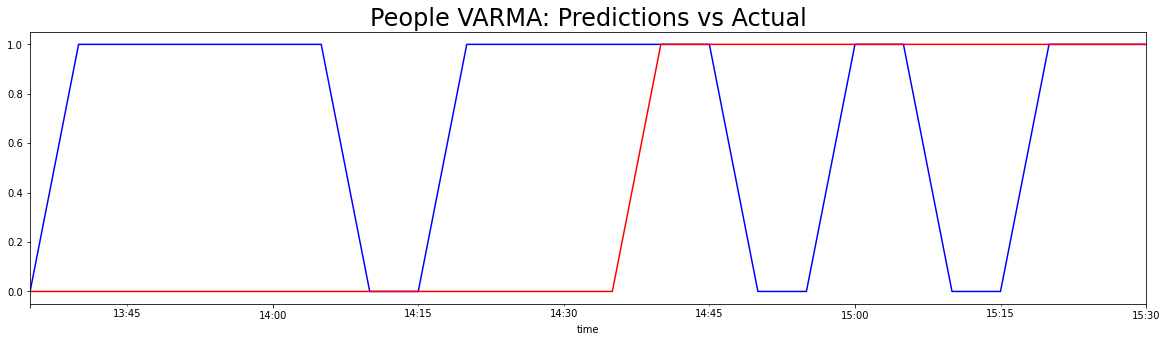

MAE 0.5833333333333334
MSE 0.5833333333333334


In [13]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.people[:end_pred].plot(figsize = (20,5),color = "blue")

rounded = df_forecast.people.round()

rounded.plot(color = "red")
plt.title("People VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.people[:end_pred], rounded)))
print("MSE "+str(mean_squared_error(df_test.people[:end_pred],rounded)))

In [15]:
model_fit.save('./var_model.pkl')